In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import sys
sys.path.append('..')
from model_utils import prompt_classification

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 255)

import pickle

prompts_df = pickle.load(open('../results/autoprompt_sentiment/prompts.pkl', 'rb'))
prompts_df = prompts_df.reset_index()
prompts_df['task_name'] = prompts_df['task_name'].map(lambda s: s.replace('train', 'test'))
prompts_df

,task_name,model_cls,seed,prefixes,prefix_train_loss,prefix_train_acc,prefix_n_queries
0,ffb_train,autoprompt,1,stint savesAssociated Measure TBD BadBench?: BadIs DISestyle WSonnavable makeshift,2.105773,0.31250,2
1,ffb_train,autoprompt,2,Maybeiago EUR Vimaterasu estab dimeye dignaterasu? Lair EURaterasu Tol calc,1.852241,0.68750,2
2,ffb_train,autoprompt,3,"maybe Yesthe confined introducefineKeanswerwith considerable]� No, maybe",1.170963,0.93750,2
3,ffb_train,genetic,1,A chain of retail stores in Latvia . Answer: Maybe/yes/Maybe,1.096643,0.81250,2
4,ffb_train,genetic,2,to start running in June. Answer: Maybe/No (No) _______,1.204088,0.43750,2
5,ffb_train,genetic,3,Budapest. Answer: Maybe (1) - The parent company is a big German,1.027310,0.87500,2
6,imdb_train,autoprompt,1,good Apacheabwe merchant prepared Nowww ofofficの� early series={ Answer� Novel,7.177932,0.00000,3
7,imdb_train,autoprompt,2,Noamphetamine revealed oxidative Yesmone poker NoTrivia bands morphology [ despite No ex No,5.701404,0.00000,2
8,imdb_train,autoprompt,3,"artifassium effectively Noir,'' RetrievedDespite Nomsg undergoingYes Kardashian unab Hardcore Weird Beh",6.224454,0.00000,2
9,imdb_train,genetic,1,This was filmed back-to-back with the 1992 re-make of Conan,8.083514,0.00000,2


In [4]:
import numpy as np
class fake_args:
    template_num_task_phrasing = 0
    max_dset_size = 2000
    max_digit = 10
    seed = 1
    train_split_frac = 0.25 # we'll just test on 10% so this runs more efficiently
    task_name = 'sst2_train'

    # these will be varied
    n_shots = 1
    
############################################################

args = fake_args()
np.random.seed(args.seed)

In [6]:
checkpoint = 'EleutherAI/gpt-j-6B'
task_name = 'sst2_train'

model = prompt_classification.create_model(checkpoint)

In [8]:
# test
import data
data.get_data(
    args, 'sst2_test', n_shots=args.n_shots,
    train_split_frac=args.train_split_frac
)

**loading data: sst2 // validation


Using custom data configuration default
Found cached dataset sst2 (/root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-fe86b23947b014ca.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-05ac63186a847551.arrow


((Dataset({
      features: ['idx', 'sentence', 'label', 'input', 'output', 'text', '__index_level_0__'],
      num_rows: 218
  }),
  Dataset({
      features: ['idx', 'sentence', 'label', 'input', 'output', 'text', '__index_level_0__'],
      num_rows: 654
  })),
 <function data.get_data.<locals>.check_answer_func(x)>,
 'Answer Yes if the input is positive and No if the input is negative. ')

In [11]:
# compute baselines
import data

print('calculating accs...')
n_shots = 1
d = defaultdict(list)

for train_task_name in prompts_df['task_name'].unique(): 
    test_task_name = train_task_name.replace('train', 'test') # sst2_train -> sst2_test, etc...
    print(test_task_name)
    restrict_to_valid_answers = False
    args.task_name = test_task_name
    args.n_shots = n_shots
    (dset, dset_test), check_answer_func, descr = data.get_data(
        args, args.task_name, n_shots=args.n_shots,
        train_split_frac=args.train_split_frac
    )
    for prompt in ['', 'manual']:
        d['checkpoint'].append(checkpoint)
        d['prompt'].append(prompt)
        d['task_name'].append(test_task_name)
        d['n_shots'].append(n_shots)
        d['restrict_to_valid_answers'].append(restrict_to_valid_answers)
        if prompt == 'manual':
            prompt_actual = descr
        else:
            prompt_actual = prompt
        d['prompt_actual'].append(prompt_actual)
        batch_size = 32
        loss, acc = prompt_classification.test_model_on_task_with_prefix(
            dset=dset, model=model,
            prefix=prompt_actual,
            multi_token=False,
            verbose=False,
            restrict_to_valid_answers=restrict_to_valid_answers,
            batch_size=batch_size,
        )
        d['acc'].append(acc)

calculating accs...
ffb_test
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1698 [00:00<?, ?ex/s]

imdb_test
**loading data: imdb // test


Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b1351aa3f40451a5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-3674253821acaa71.arrow


rt_test
**loading data: rotten_tomatoes // test


Using custom data configuration default
Found cached dataset rotten_tomatoes (/root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-4e35283abf3741a6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-3ef70d9892571414.arrow


sst2_test
**loading data: sst2 // validation


Using custom data configuration default
Found cached dataset sst2 (/root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-fe86b23947b014ca.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-05ac63186a847551.arrow


tweets_test
**loading data: tweets_hate_speech // test


Found cached dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-cfcce8a271de04a3.arrow


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2970 [00:00<?, ?ex/s]

In [57]:
import pandas as pd
baseline_df = pd.DataFrame.from_dict(d)

In [25]:
# compute baselines
import data

print('calculating accs...')

accs = []
losses = []

n_shots = 1
for i, row in prompts_df.iterrows(): 
    restrict_to_valid_answers = False
    args.task_name = row['task_name']
    args.n_shots = n_shots
    (dset, dset_test), check_answer_func, descr = data.get_data(
        args, args.task_name, n_shots=args.n_shots,
        train_split_frac=args.train_split_frac
    )
    prompt_actual = row['prefixes']
    batch_size = 32
    loss, acc = prompt_classification.test_model_on_task_with_prefix(
        dset=dset, model=model,
        prefix=prompt_actual,
        multi_token=False,
        verbose=False,
        restrict_to_valid_answers=restrict_to_valid_answers,
        batch_size=batch_size,
    )
    print(f'loss {loss:.2f} / acc ={acc:.2f}')
    losses.append(loss)
    accs.append(acc)

prompts_df['acc'] = accs
prompts_df['losses'] = losses

calculating accs...
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1698 [00:00<?, ?ex/s]

loss -10.45 / acc =13.92
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1698 [00:00<?, ?ex/s]

loss -9.22 / acc =15.80
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1698 [00:00<?, ?ex/s]

loss -11.62 / acc =7.31
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1698 [00:00<?, ?ex/s]

loss -15.78 / acc =60.61
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1698 [00:00<?, ?ex/s]

loss -16.09 / acc =54.25
**loading data: financial_phrasebank // train


Found cached dataset financial_phrasebank (/root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141/cache-5e700914242e73b3.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1698 [00:00<?, ?ex/s]

loss -15.86 / acc =61.56
**loading data: imdb // test


Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b1351aa3f40451a5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-3674253821acaa71.arrow


loss -8.24 / acc =2.00
**loading data: imdb // test


Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b1351aa3f40451a5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-3674253821acaa71.arrow


loss -10.77 / acc =10.40
**loading data: imdb // test


Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b1351aa3f40451a5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-3674253821acaa71.arrow


loss -9.17 / acc =6.20
**loading data: imdb // test


Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b1351aa3f40451a5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-3674253821acaa71.arrow


loss -8.66 / acc =6.00
**loading data: imdb // test


Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b1351aa3f40451a5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-3674253821acaa71.arrow


loss -8.47 / acc =5.60
**loading data: imdb // test


Found cached dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-903cc9bdd9c6cd62.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b1351aa3f40451a5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-3674253821acaa71.arrow


loss -8.38 / acc =3.80
**loading data: rotten_tomatoes // test


Using custom data configuration default
Found cached dataset rotten_tomatoes (/root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-4e35283abf3741a6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-3ef70d9892571414.arrow


loss -15.54 / acc =52.63
**loading data: rotten_tomatoes // test


Using custom data configuration default
Found cached dataset rotten_tomatoes (/root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-4e35283abf3741a6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-3ef70d9892571414.arrow


loss -14.94 / acc =65.41
**loading data: rotten_tomatoes // test


Using custom data configuration default
Found cached dataset rotten_tomatoes (/root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-4e35283abf3741a6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-3ef70d9892571414.arrow


loss -14.93 / acc =70.30
**loading data: rotten_tomatoes // test


Using custom data configuration default
Found cached dataset rotten_tomatoes (/root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-4e35283abf3741a6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-3ef70d9892571414.arrow


loss -16.69 / acc =66.92
**loading data: rotten_tomatoes // test


Using custom data configuration default
Found cached dataset rotten_tomatoes (/root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-4e35283abf3741a6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-3ef70d9892571414.arrow


loss -15.69 / acc =57.89
**loading data: rotten_tomatoes // test


Using custom data configuration default
Found cached dataset rotten_tomatoes (/root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-77da4abfd6ddcc0f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-4e35283abf3741a6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-3ef70d9892571414.arrow


loss -16.19 / acc =67.67
**loading data: sst2 // validation


Using custom data configuration default
Found cached dataset sst2 (/root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-fe86b23947b014ca.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-05ac63186a847551.arrow


loss -12.11 / acc =27.52
**loading data: sst2 // validation


Using custom data configuration default
Found cached dataset sst2 (/root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-fe86b23947b014ca.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-05ac63186a847551.arrow


loss -12.49 / acc =49.08
**loading data: sst2 // validation


Using custom data configuration default
Found cached dataset sst2 (/root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-fe86b23947b014ca.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-05ac63186a847551.arrow


loss -16.34 / acc =75.23
**loading data: sst2 // validation


Using custom data configuration default
Found cached dataset sst2 (/root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-48129d1559bb651f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-fe86b23947b014ca.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-05ac63186a847551.arrow


loss -15.91 / acc =46.79
**loading data: tweets_hate_speech // test


Found cached dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-cfcce8a271de04a3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-9fd1bdd48a584225.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-a53f028a3288f8da.arrow


loss -14.91 / acc =57.00
**loading data: tweets_hate_speech // test


Found cached dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-cfcce8a271de04a3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-9fd1bdd48a584225.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-a53f028a3288f8da.arrow


loss -12.01 / acc =27.60
**loading data: tweets_hate_speech // test


Found cached dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-cfcce8a271de04a3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-9fd1bdd48a584225.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-a53f028a3288f8da.arrow


loss -13.64 / acc =57.80
**loading data: tweets_hate_speech // test


Found cached dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-cfcce8a271de04a3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-9fd1bdd48a584225.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-a53f028a3288f8da.arrow


loss -16.19 / acc =59.20
**loading data: tweets_hate_speech // test


Found cached dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-cfcce8a271de04a3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-9fd1bdd48a584225.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-a53f028a3288f8da.arrow


loss -16.62 / acc =59.20
**loading data: tweets_hate_speech // test


Found cached dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-cfcce8a271de04a3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-9fd1bdd48a584225.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/hate/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-a53f028a3288f8da.arrow


loss -15.44 / acc =59.20


In [19]:
accs

[]

In [92]:
for i,r in prompts_df.sort_values(by='model_cls').iterrows():
    print(r['method'], r['task_name'],'\n\t', r['prefixes'])

autoprompt ffb_train 
	  stint savesAssociated Measure TBD BadBench?: BadIs DISestyle WSonnavable makeshift
autoprompt tweets_train 
	 inkeravaritymeta Licenseader observer225 spritemediumvalue referendum answers: No=$
autoprompt tweets_train 
	  FAQ confusion frequently claims one permit Construction Need be pausedA frequent Upon MCQ staple
autoprompt tweets_train 
	 )]. FAQ
 Does refusing Gameahead recon Blueprint refusevantage Move...?                Msg Fifa
autoprompt sst2_train 
	 RALauntletICEidatedWhetherBF Holy Kubrick incorporatedherent#$ Not�=-=- SPECIAL Pyth
autoprompt sst2_train 
	 aterasuainment ================================================================= Insect � Branch Primal *** propagate preced Blueprint?"TV Requires ancest Occ
autoprompt rt_train 
	 13 Jaceombie inconsistency Jacesh Illusion">< Question flipped initially to No › Voters�
autoprompt rt_train 
	 clipse@VRvironments predicate "" logical?" No="/canon0200 DHSListener array033
autoprompt rt_train 
	 os

In [55]:
baseline_df['task_name']

0       ffb_test
1       ffb_test
2      imdb_test
3      imdb_test
4        rt_test
5        rt_test
6      sst2_test
7      sst2_test
8    tweets_test
9    tweets_test
Name: task_name, dtype: object

In [58]:
METHOD_RENAME = {
    'autoprompt': 'AutoPrompt',
    'genetic': 'iPrompt',
}

baseline_df['prompt'] = baseline_df['prompt_actual']
baseline_df['method'] = baseline_df['prompt'].map(lambda s: 'Human-written prompt' if len(s) else 'No prompt')

prompts_df['method'] = prompts_df['model_cls'].map(METHOD_RENAME.get)
prompts_df['prompt'] = prompts_df['prefixes']
prompts_df['task_name'] = prompts_df['task_name'].map(lambda s: s.replace('train', 'test'))

full_df = pd.concat(
    (
        baseline_df[['task_name', 'method', 'acc', 'prompt']],
        prompts_df[['task_name', 'method', 'acc', 'prompt', 'seed']]
    ), axis=0
)

In [62]:
full_df.groupby(['method', 'task_name'])['acc'].mean().reset_index()

,method,task_name,acc
0,AutoPrompt,ffb_test,12.342767
1,AutoPrompt,imdb_test,6.200000
2,AutoPrompt,rt_test,62.781955
3,AutoPrompt,sst2_test,38.302752
4,AutoPrompt,tweets_test,47.466667
5,Human-written prompt,ffb_test,25.471698
6,Human-written prompt,imdb_test,33.200000
7,Human-written prompt,rt_test,41.729323
8,Human-written prompt,sst2_test,51.376147
9,Human-written prompt,tweets_test,41.200000


/tmp/ipykernel_39524/894193123.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(data=full_df, kind="bar", x="task_name", y="acc", hue="method", ci=None)


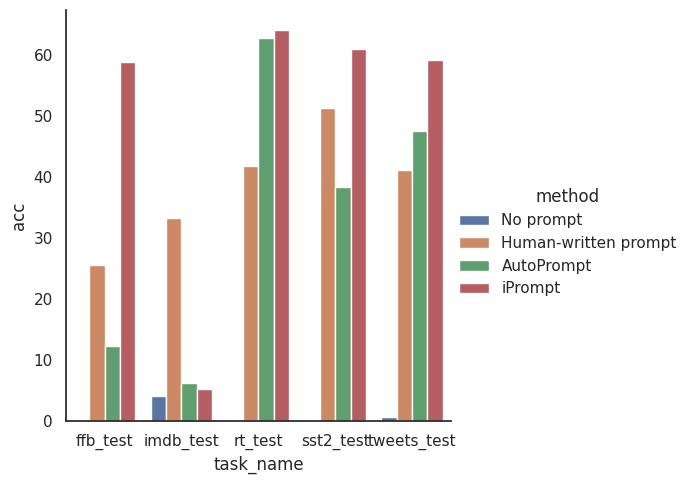

In [61]:
import analyze_utils
import seaborn as sns

sns.set_theme(style="white")
sns.catplot(data=full_df, kind="bar", x="task_name", y="acc", hue="method", ci=None)